<a href="https://colab.research.google.com/github/shirakashi-jinnai/practice_tensorlflow/blob/main/practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tensorflow version:2.8.2
4431872/4422102 [==============================] - 0s 0us/step
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]] [9 0 0 ... 3 0 5] print train
Running on TPU ['10.107.246.2:8470']
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.107.246.2:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.107.246.2:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Replicas: 8
Epoch 1/5
60/60 [==============================] - 4s 16ms/step - loss: 15.2134 - sparse_categorical_accuracy: 0.7064
Epoch 2/5
60/60 [==============================] - 1s 14ms/step - loss: 0.6963 - sparse_categorical_accuracy: 0.8626
Epoch 3/5
60/60 [==============================] - 1s 14ms/step - loss: 0.4167 - sparse_categorical_accuracy: 0.8833
Epoch 4/5
60/60 [==============================] - 1s 16ms/step - loss: 0.3183 - sparse_categorical_accuracy: 0.8986
Epoch 5/5
60/60 [==============================] - 8s 129ms/step - loss: 0.2701 - sparse_categorical_accuracy: 0.9075 - val_loss: 0.3886 - val_sparse_categorical_accuracy: 0.8810
n= 16
range 9
range 2
range 1
range 1
range 6
range 1
range 2
range 6
range 5
range 7
range 4
range 5
range 8
range 3
range 4
range 1


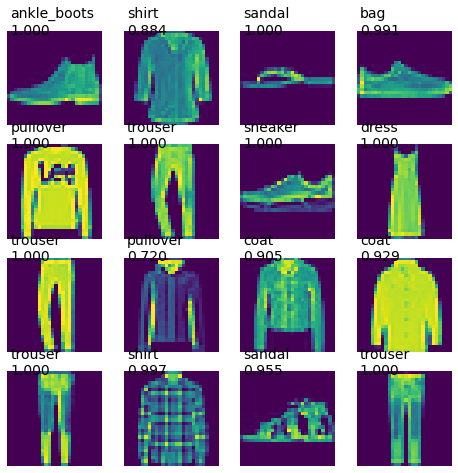

In [ ]:
#TensorFlow を import して version を check　します
import tensorflow as tf
print('Tensorflow version:'+tf.__version__)

# tf.keras.datasets を使用して,ファッションMNISTデータセットをダウンロードすることから始めます
import numpy as np

test_data = tf.keras.datasets.fasion_mnist.load_data()



(x_train,y_train),(x_test,y_test)=tf.keras.datasets.fashion_mnist.load_data()

# add empty color dimension
x_train = np.expand_dims(x_train,-1)
x_test = np.expand_dims(x_test,-1)

# 次の例では3つのレイヤーを持つ標準の conv-net を使用し、各レイヤー間でドロップアウトとバッチ正規化を行います
def create_model():
  model=tf.keras.models.Sequential()

  model.add(tf.keras.layers.Conv2D(128,(3,3),input_shape=x_train.shape[1:]))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
  model.add(tf.keras.layers.Activation('elu'))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(10))
  model.add(tf.keras.layers.Activation('softmax'))

  return model

# トレーニングを開始するために TPU でモデルを作成してからコンパイルします
import os 

# TF 1.x
# resolver = tf.tpu.cont .cluster_resolver.TPUClusterResolver(tpu='grpc://'+os.environ['COLAB_TPU_ADDR'])
# tf.tpu.experimental.initialize_tpu_system(resolver)
# strategy=tf.distribute.experimental.TPUStrategy(resolver)

tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
print('Running on TPU',tpu.cluster_spec().as_dict()['worker'])

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

strategy = tf.distribute.experimental.TPUStrategy(tpu)
print('Replicas:',strategy.num_replicas_in_sync)

#
# Create model with TPU strategy
#
with strategy.scope():
  model = create_model()
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
      loss=tf.keras.losses.sparse_categorical_crossentropy,
      metrics=[tf.keras.metrics.sparse_categorical_accuracy])

  model.fit(
      x_train.astype(np.float32),y_train.astype(np.float32),
      epochs=5,
      steps_per_epoch=60,
      validation_data=(x_test.astype(np.float32),y_test.astype(np.float32)),
      validation_freq=5
  )

  model.save_weights('./fashion_mnist.h5',overwrite=True)

  # 以上で TPU によるトレーニングが終了したので、モデルファッションカテゴリをどれだけ予測できるか見てみましょう
  LABEL_NAMES=['t_shirt','trouser','pullover','dress','coat','sandal','shirt','sneaker','bag','ankle_boots']

  cpu_model=create_model()
  cpu_model.load_weights('./fashion_mnist.h5')

  from matplotlib import pyplot
  %matplotlib inline

  def plot_predictions(images,predictions):
    n= images.shape[0]
    print('n=',n)
    nc = int(np.ceil(n/4))
    f,axes = pyplot.subplots(nc,4)
    for i in range(nc*4):
      y = i // 4
      x = i% 4
      axes[x,y].axis('off')
      print('range',np.argmax(predictions[i]))

      label = LABEL_NAMES[np.argmax(predictions[i])]
      confidence = np.max(predictions[i])

      if i > n:
        continue
      axes[x,y].imshow(images[i])
      axes[x,y].text(0.5,0.5,label+'\n%.3f'% confidence,fontsize=14)
    
    pyplot.gcf().set_size_inches(8,8)
  
  # print('→',x_test[:16],cpu_model.predict(x_test[:16]))

  plot_predictions(np.squeeze(x_test[:16]),cpu_model.predict(x_test[:16]))





In [1]:
#TensorFlow を import して version を check　します
import tensorflow as tf
print('Tensorflow version:'+tf.__version__)

# tf.keras.datasets を使用して,ファッションMNISTデータセットをダウンロードすることから始めます
import numpy as np

# データセットをロードし、サンプルを整数から浮動小数点に変換
test_data = tf.keras.datasets.fashion_mnist.load_data()
(x_train,y_train),(x_test,y_test)= tf.keras.datasets.mnist.load_data()
x_train,x_test=x_train/255.0,x_test/255.0

def model_creater():
  model = tf.keras.models.Sequential()
  layers=tf.keras.layers
  model.add(layers.Flatten(input_shape=(28,28)))
  model.add(layers.Dense(128,activation='relu'))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(10))
  return model

model = model_creater()

predictions = model(x_train[:1]).numpy()
print(predictions)

# クラスごとにこれらのロジットを確立に変換します
tf.nn.softmax(predictions).numpy()

# 損失関数は、ロジットと True の インデックスに関するベクトルを入力にとり、それぞれの標本についてクラスごとに損失のスカラーを返します。
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

loss_fn(y_train[:1],predictions).numpy()

model.compile(optimizer='adam',loss=loss_fn,metrics=['accuracy'])

#Model.fitメソッドは損失を最小化するようにモデルのパラメータを調整します
model.fit(x_train,y_train,epochs=5)

# evaluteメソッドはモデルの性能を検査します。これには通常検査用データセットorテストデータセットを用います
model.evaluate(x_test,y_test,verbose=2)

# モデルが確立を返すようにしたい場合は、モデルをラップしてソフトマックス関数を適用する
probability_model=tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

probability_model(x_test[:5])

Tensorflow version:2.8.2
11501568/11490434 [==============================] - 0s 0us/step
[[-0.47402987 -0.38389203  0.57695293 -0.05610029  0.13412967  0.01595534
   0.25986305  0.10690358 -0.68886256 -0.2988682 ]]
Epoch 1/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2986 - accuracy: 0.9128
Epoch 2/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1448 - accuracy: 0.9574
Epoch 3/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1079 - accuracy: 0.9675
Epoch 4/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0881 - accuracy: 0.9728
Epoch 5/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0747 - accuracy: 0.9768
313/313 - 1s - loss: 0.0751 - accuracy: 0.9759 - 543ms/epoch - 2ms/step


<tf.Tensor: shape=(5, 10), dtype=float32, numpy=
array([[2.3677410e-07, 9.3771803e-07, 9.5810747e-06, 1.9379146e-05,
        1.2898265e-11, 1.2616352e-08, 8.9471350e-13, 9.9996805e-01,
        1.3884258e-07, 1.6985225e-06],
       [1.0148802e-06, 1.0104104e-02, 9.8985821e-01, 2.2000602e-06,
        4.4590972e-12, 2.8448136e-05, 5.7923853e-06, 2.6282871e-12,
        1.6154320e-07, 1.9713536e-10],
       [2.1990607e-07, 9.9927682e-01, 3.9894352e-04, 9.1589927e-06,
        8.7971621e-06, 9.2834534e-06, 3.2931632e-05, 1.8868162e-04,
        7.4852433e-05, 3.5275369e-07],
       [9.9995744e-01, 1.7589139e-08, 2.4965413e-05, 8.4327361e-08,
        2.2455919e-07, 1.1824781e-06, 6.9383991e-06, 2.3944303e-06,
        1.7479742e-08, 6.6118328e-06],
       [2.1948872e-05, 1.0602813e-09, 6.2490240e-06, 9.7491428e-09,
        9.9200636e-01, 2.4951461e-07, 3.0542337e-06, 2.2932338e-04,
        2.4337737e-07, 7.7325231e-03]], dtype=float32)>